In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import PCA

import torch
from torch import tensor as tt

from utils import *
from torch_models import *

from ipywidgets import interact


In [37]:
def make_design_matrix(cell_identifiers):
    """A function to create a generic design matrix from cell identifiers

    For example:
    input, cell_identifiers = [1,1,1,2,2,2]
    output, design_matrix: [[1,1,1,0,0,0][0,0,0,1,1,1]]

    Arguments
    ---------
    cell_identifiers: torch tensor
        List of cells identifiers, should be of type torch.int

    Returns
    -------
    design_matrix: torch tensor
        Design matrix of shape (num_cells, num_unique_identifiers)

    """
    design_matrix = torch.hstack(
        [
            (cell_identifiers == v).type(torch.float).reshape(len(cell_identifiers), 1)
            for i, v in enumerate(torch.unique(cell_identifiers))
        ]
    )
    return design_matrix

In [38]:
# load dataset
scData = pd.read_csv("data/190923_Neuron_1.csv")
scData = scData.T
col_names = scData.iloc[0, :].values
# delete first row

scData = scData.drop(scData.index[0])
scData.columns = col_names
scData["Vip"].mean()

# create anndata object
E_sc = anndata.AnnData(scData)
E_sc.X = E_sc.X.astype(float)

In [39]:
# load daset
time = pd.read_csv("data/190923_Neuron_1_metadata.csv")

labels = time["labels"].values
phase_inf = time["phase_inf"].values

# add to the anndata object
E_sc.obs["labels"] = labels
E_sc.obs["phase_inf"] = phase_inf
#filtering stuff


In [40]:
# take the index of scData it's a list of strings
# split every string by '_' and take the first element, fro the first element remove lettter X
# and then convert to int
# this is the sample index
sample_index = np.array(
    [int(s.split("_")[0][1:]) for s in E_sc.obs.index.values.tolist()]
)
sample_index


array([14, 14, 14, ..., 58, 58, 58])

In [41]:
# remove columns/genes with all zeros
E_sc = E_sc[:, E_sc.X.sum(axis=0) != 0]
# normalize per cell
E_sc.layers["norm"] = E_sc.X / E_sc.X.sum(axis=1).reshape(-1, 1)
# now standardize the data
E_sc.layers["stand"] = (
    E_sc.layers["norm"] - E_sc.layers["norm"].mean(axis=0)
) / E_sc.layers["norm"].std(axis=0)
E_sc.obs["counts"] = E_sc.X.sum(axis=1)

In [42]:
# load the fitted coef
coef_2D = pd.read_csv(
    "fit/theta_2D.csv",
)
zonated_genes = coef_2D["Unnamed: 0"].values
theta_2D = coef_2D.values[:, 1:]
theta_2D = theta_2D.astype(float)

In [43]:
sc_zon = zonated_genes[zonated_genes != "Prokr2"]
sc_small = E_sc[:, sc_zon]

NC, NG = sc_small.shape


In [44]:
sc_small.layers["norm"].astype(float)
corr_cells = np.corrcoef(sc_small.layers["norm"].astype(float))
corr_genes = np.corrcoef(sc_small.layers["norm"].astype(float).T)

/Users/salati/miniforge3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/salati/miniforge3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [45]:
# load the fitted coef
coef_2D = pd.read_csv(
    "fit/theta_2D.csv",
)
zonated_genes = coef_2D["Unnamed: 0"].values
theta2 = coef_2D.values[:, 1:]
theta2.shape

(9, 5)

## finding seed values for x,y,z

In [46]:
# here  I create the mask_z which filters out cells with NO spatial infromation
# zero counts for all zonated genes

zonated_counts = sc_small.X.sum(axis=1)
mask_z = zonated_counts != 0
print(mask_z.sum())
# now remove cells that have zeros in all zonated genes
sc_small = sc_small[mask_z, :]

labelss = labels[mask_z]
phase_infs = phase_inf[mask_z]



3020


In [47]:
# create the design matrix
DM = make_design_matrix(tt(labelss))
NS = DM.shape[1]


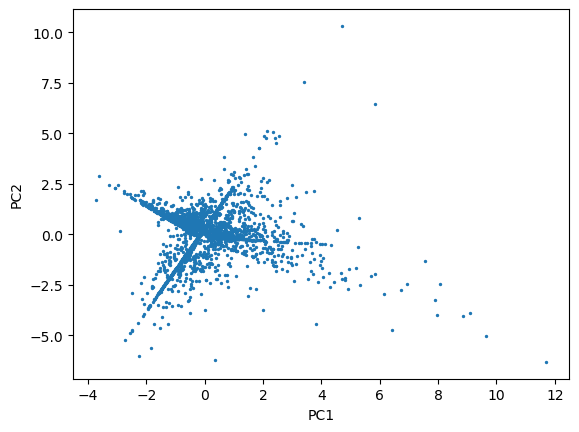

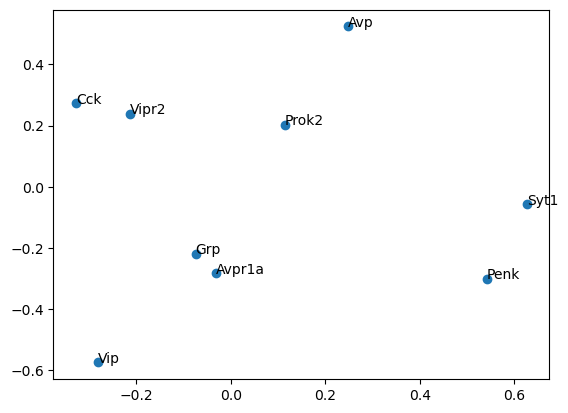

In [48]:
# perform PCA and plot the first 2 components
pca = PCA(n_components=2)
PC = pca.fit_transform(sc_small.layers["stand"])
vec = pca.components_

# plot the first 2 components
plt.scatter(PC[:, 0], PC[:, 1], s=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# plot the loadings of the first 2 components
plt.scatter(vec[0, :], vec[1, :])
# now annotate with gene names
for i, g in enumerate(sc_zon):
    plt.annotate(g, (vec[0, i], vec[1, i]))

In [49]:
# print mean, and variance for the normalized cut of every gene, next to the gene name
for i, g in enumerate(sc_zon):
    print(g, sc_small[:, g].layers["norm"].mean(), sc_small[:, g].layers["norm"].var())


Vip 0.004168980557466908 0.00011980215386873495
Avp 0.005590197995291927 0.00017522252690295903
Prok2 6.602918039254667e-05 1.8395181801524485e-07
Penk 0.0002131344766732339 9.068027370466524e-07
Vipr2 0.0005376401553992967 9.36010444886659e-07
Avpr1a 4.151496475663759e-05 7.345211199322207e-08
Cck 0.0009145474225289935 6.680407061961441e-06
Grp 7.037686005509476e-05 3.2640422869857734e-07
Syt1 0.0005722104146576337 1.375506479785902e-06


## trying to order cells

In [50]:
order_z = np.argsort(np.argsort(sc_small[:, "Penk"].layers["norm"]))
np.argsort(sc_small[:, "Penk"].layers["norm"].squeeze()).sum()


array(4558690)

In [51]:
# now take gene Penk and get the argsort. This will give the order of the cells
# after standardize this position vecotr

# get the order of the cells
order_z = np.argsort(np.argsort(sc_small[:, "Penk"].layers["norm"]).squeeze())
z_guess = (order_z - order_z.mean()) / order_z.std()
order_z

# do the same for gene Vip
order_y = np.argsort(np.argsort(sc_small[:, "Vip"].layers["norm"]).squeeze())
y_guess = (order_y - order_y.mean()) / order_y.std()
order_y

ArrayView([   0, 2008, 2009, ..., 1011, 1002, 3019])

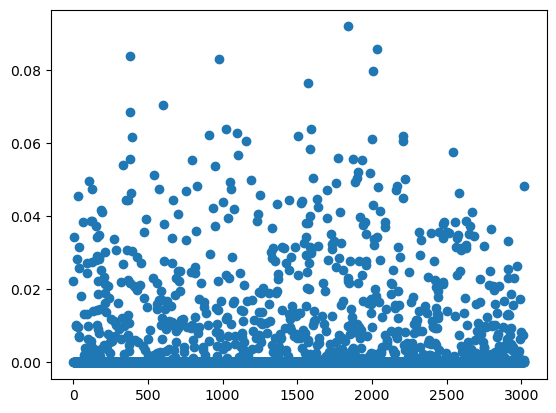

In [52]:
# plt.scatter(np.linspace(0 , 1, NC), sc_small[:, 'Penk'].layers['norm'])
plt.scatter(order_y, sc_small[:, "Vip"].layers["norm"])

# torch

In [53]:
# non leaf vectors
Y = tt(sc_small[:, :].layers["norm"])
Y_counts = tt(sc_small[:, :].X)
sc_counts = tt(sc_small.obs["counts"].values, dtype=torch.float32)


In [54]:
X = torch.randn(Y.shape[0], 2, requires_grad=True)
theta2 = tt(theta_2D)
# convert onated dataset to tesor

disp = tt(0.3, requires_grad=True)

# gettign the constant and preparing the C parameter
C = theta_2D[:,4].astype(np.dtype('float32'))
C = tt(C)
# repeat this vector N_sample ona  new dimension
C = C.repeat(NS, 1)
C.requires_grad = True


In [55]:
def model_2D_DM(X, Y, theta, C, disp, n_count, dm, batch_size=64):
    """
    this model introduces a sample dependent parameter in the model
    in order to disentangle the effect of the sample from the effect of the position
    while before all gene related coefficients where constant,
    now they are sample dependent, and will be optimized
    """
    NC = Y.shape[0]
    idx = torch.randperm(NC)[:batch_size]

    lmbda = (
        theta[:, 0][None, :] * X[idx, 0][:, None] ** 2
        + theta[:, 1][None, :] * X[idx, 0][:, None]
        + theta[:, 2][None, :] * X[idx, 1][:, None] ** 2
        + theta[:, 3][None, :] * X[idx, 1][:, None]
        + torch.matmul(dm[idx, :], C[:, :] )
    )

    #print(lmbda.min())
    lmbda = torch.exp(lmbda) * n_count[idx, None]
    #print((lmbda==0).sum())
    alpha = torch.exp(disp)

    r = 1 / alpha
    p = alpha * lmbda / (1 + alpha * lmbda)
    
    NB = torch.distributions.NegativeBinomial(
        total_count=r, probs=p, validate_args=None
    )

    return -NB.log_prob(Y[idx, :]).sum() * (NC / batch_size)

model_2D_DM(X, Y_counts, theta2, C, disp, sc_counts, DM, batch_size=64).backward()


In [56]:
# train model
#optimizer = torch.optim.Adam([X, disp], lr=0.001)
optimizer = torch.optim.Adam([X, disp, C], lr=0.001)
losses = []

for step in range(10000):
    optimizer.zero_grad()  # zero the gradients
    # output = model_2D(X, Y, theta2)
    #output = model_2D_NB_batch(X, Y_counts, theta2, sc_counts, disp, batch_size=128)
    output = model_2D_DM(X, Y_counts, theta2, C, disp, sc_counts, DM, batch_size=64)

    output.backward()  # compute the gradients
    optimizer.step()  # update the variable
    losses.append(output.detach())

disp  0.98069465
tensor(18235.4778, dtype=torch.float64)


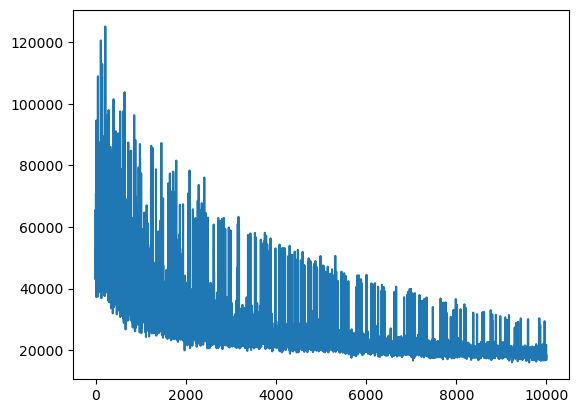

In [57]:
print("disp ", disp.detach().numpy())
print(losses[-1])
plt.plot(losses[0000:])

In [58]:
x_train = X.clone().detach().numpy()
C_train = C.clone().detach().numpy()
model_2D_NB(X, Y_counts, theta2, sc_counts, disp)

C_train[:,0]

array([-3.8189018, -3.9301283, -4.4897475, -4.403284 , -4.369264 ,
       -4.3984346, -4.034607 , -4.152703 , -3.9929762, -3.7405367,
       -3.919061 , -3.806109 ], dtype=float32)

Text(0, 0.5, 'z ant-post')

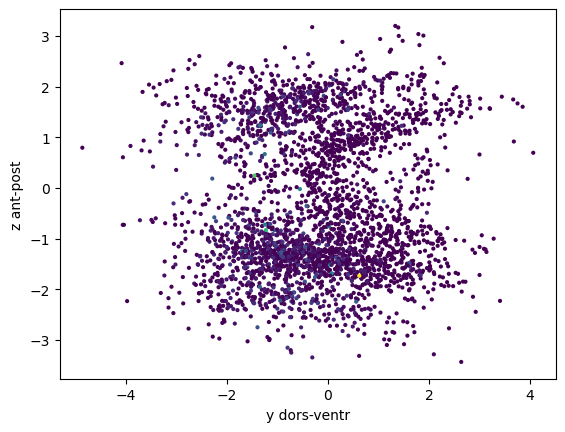

In [69]:
plt.scatter(
    x_train[:, 0], x_train[:, 1], c=sc_small[:, "Avp"].layers["norm"].squeeze(), s=4
)
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")

In [60]:
x_mean = x_train.mean(axis=0)
x_mean

# now plot the mean of the cells
# this function uses the mean of the y positiion
# to than do a 1D plot of E(x,y)
def f_x(x, y_cost, theta, gene):
    E = np.exp(
        theta[0] * x ** 2 + theta[1] * x + theta[2] * y_cost ** 2 + theta[3] * y_cost + theta[4]
    )

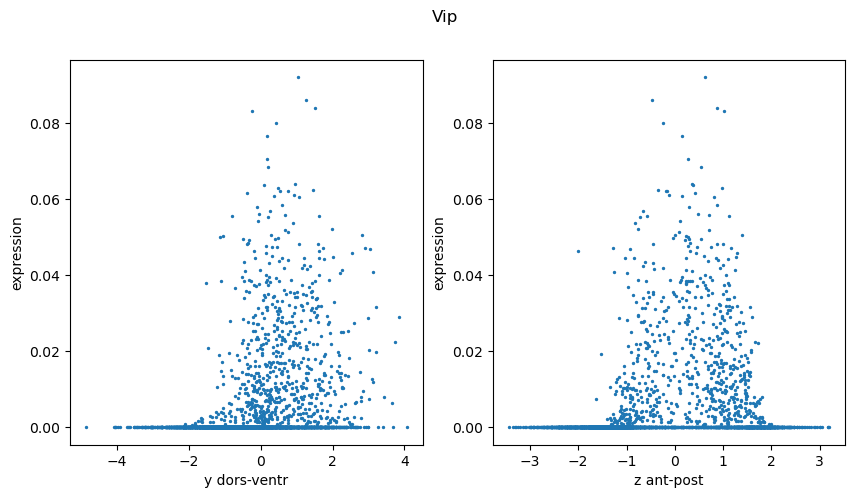

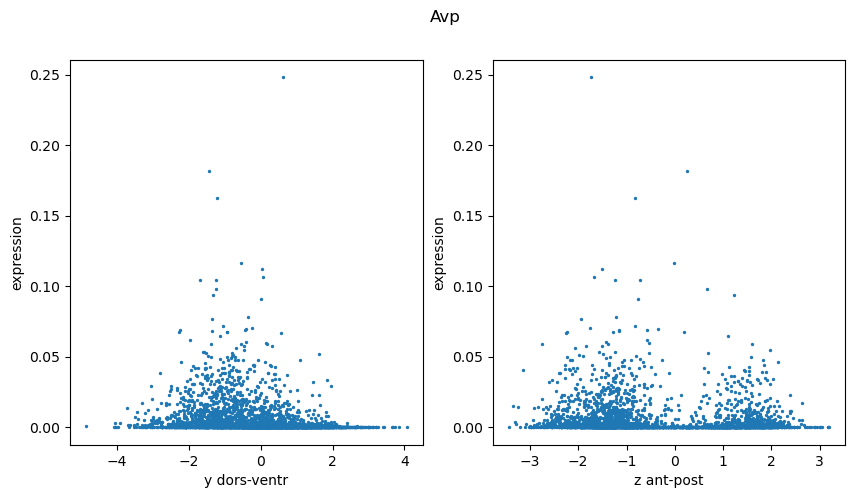

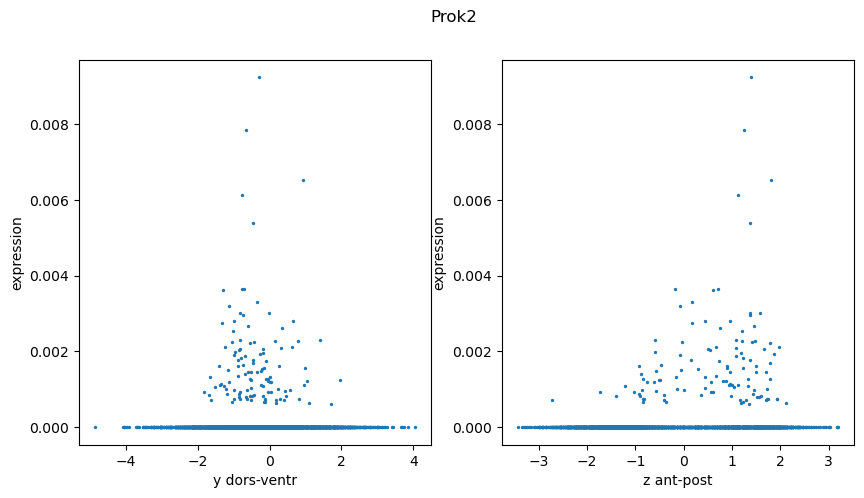

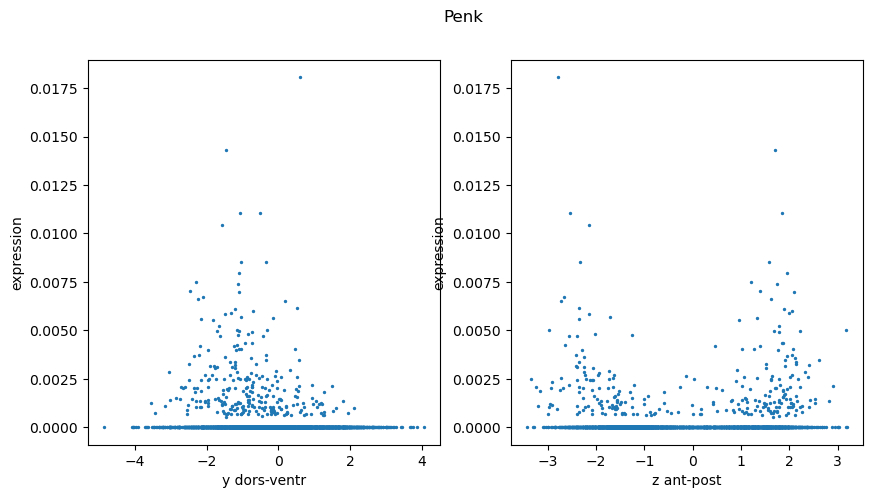

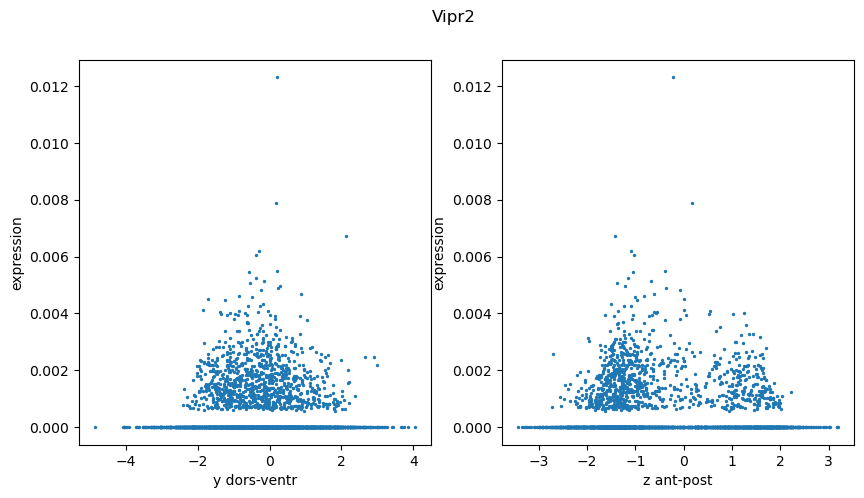

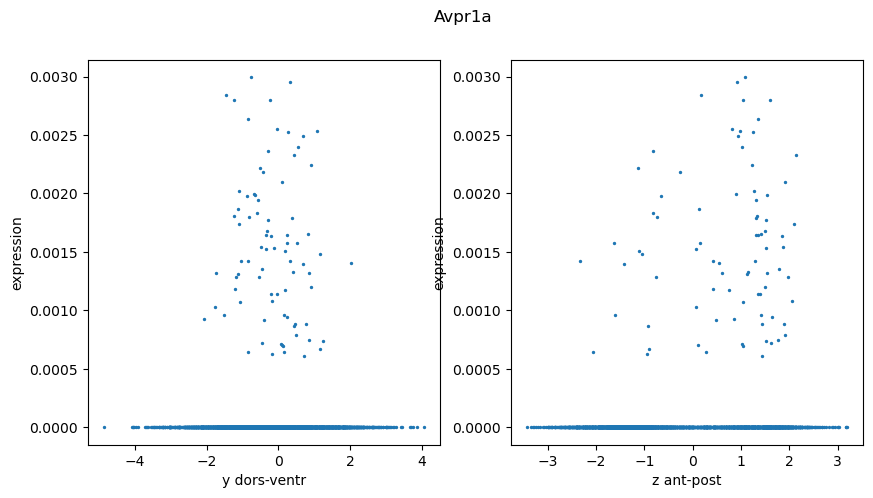

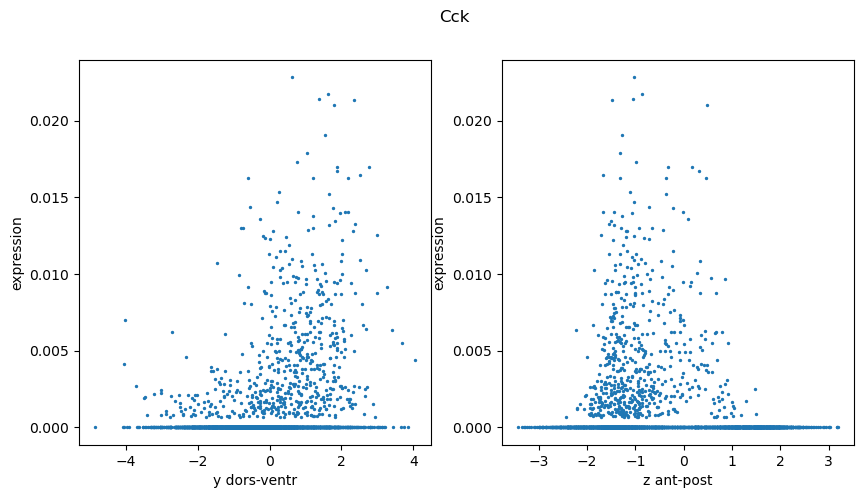

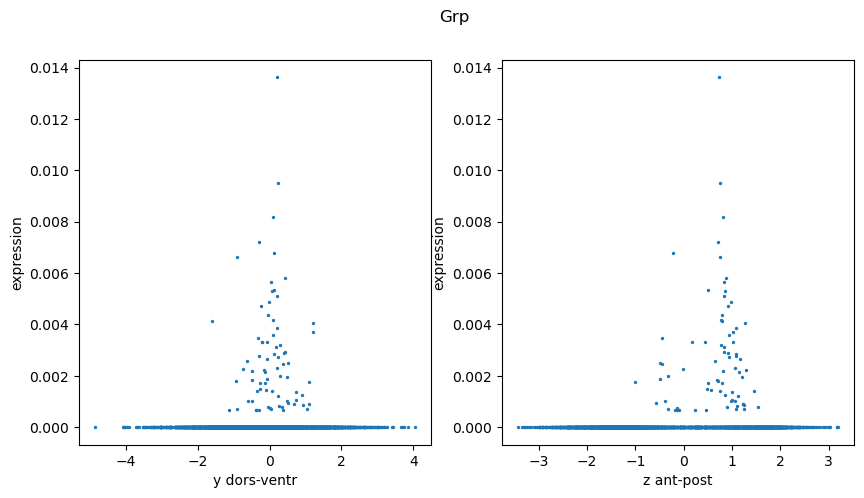

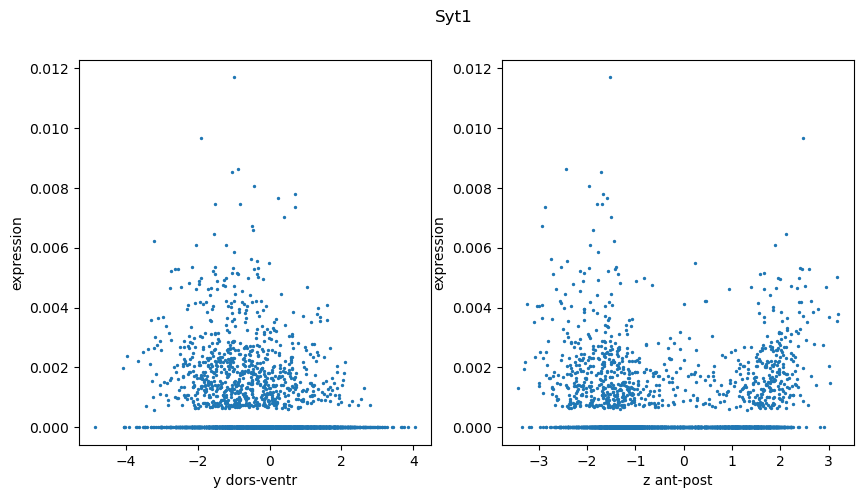

In [61]:
# plot the new x with expression of all zonated genes
# and plot the predicted fit line

for i, g in enumerate(sc_zon):
    plt.figure(figsize=(10, 5))
    plt.suptitle(g)
    plt.subplot(1, 2, 1)
    plt.scatter(x_train[:, 0], sc_small[:, g].layers["norm"], s=2)
    plt.xlabel("y dors-ventr")
    plt.ylabel("expression")

    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:, 1], sc_small[:, g].layers["norm"], s=2)
    plt.xlabel("z ant-post")
    plt.ylabel("expression")

    plt.show()

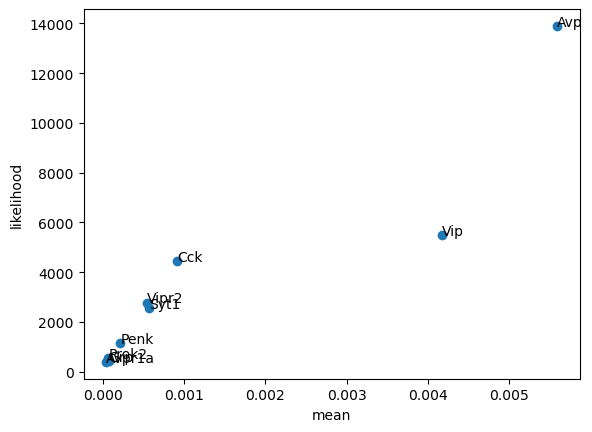

In [62]:
like = model_2D_NB_like(x_train, Y_counts, theta2, sc_counts, disp)
like_g = like.sum(axis=0).detach().numpy()

# plot now the likelihood per gene vs the gene mean
plt.scatter(sc_small[:, :].layers["norm"].mean(axis=0), like_g)
# now add annotations
for i, g in enumerate(sc_zon):
    plt.annotate(g, (sc_small[:, :].layers["norm"].mean(axis=0)[i], like_g[i]))


plt.xlabel("mean")
plt.ylabel("likelihood")
plt.show()

# phases

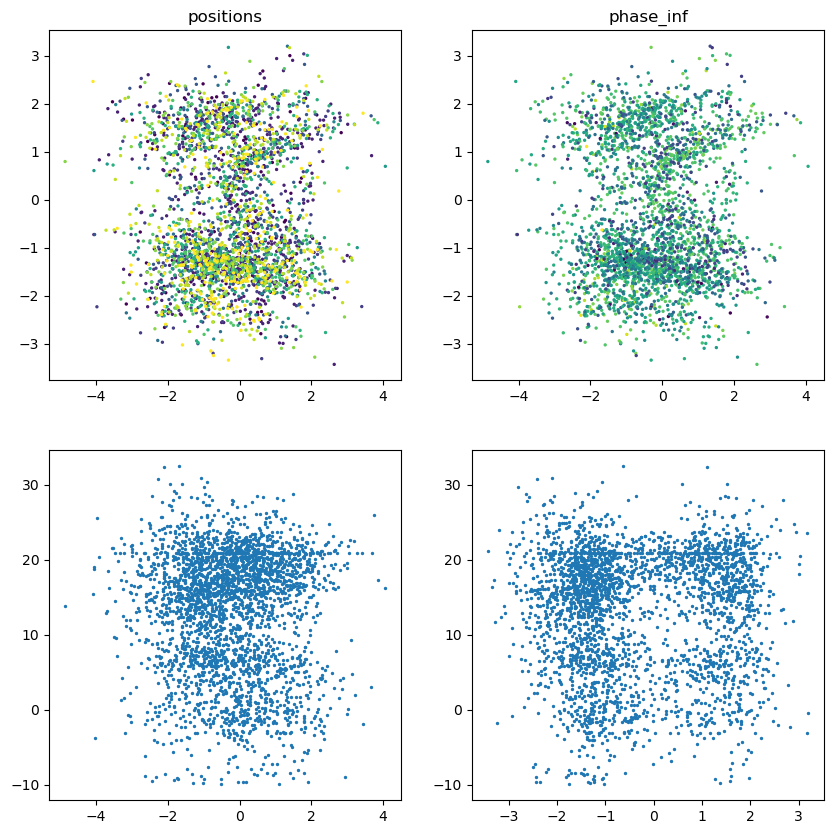

In [63]:
# quadruple plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(x_train[:, 0], x_train[:, 1], c=labelss, s=2)
axs[0, 0].set_title("positions")

axs[0, 1].scatter(x_train[:, 0], x_train[:, 1], c=phase_infs, s=2)
axs[0, 1].set_title("phase_inf")

axs[1, 0].scatter(x_train[:, 0], phase_infs, s=2)
axs[1, 1].scatter(x_train[:, 1], phase_infs, s=2)

In [64]:
# for i in np.unique(labels):
#     mask = labels == i
#     plt.scatter(x_train[mask, 0], x_train[mask, 1], s=5)
#     plt.xlabel("y dors-ventr")
#     plt.ylabel("z ant-post")
#     plt.title("14")
#     plt.show()

In [65]:
r_genes = [
    "Per1",
    "Per2",
    "Cry1",
    "Nr1d1",
    "Nr1d2",
    "Dbp",
    "Nfil3",
    "Tef",
    "Hlf",
    "Bhlhe41",
    "Ciart",
]
E_per = E_sc[:, r_genes]
labels.shape
E_per.X.sum(axis=0)

array([ 277.,  203.,  243.,  319.,  285.,  719.,   39.,  310., 1053.,
        145.,   20.])

Text(0.5, 0, 'time')

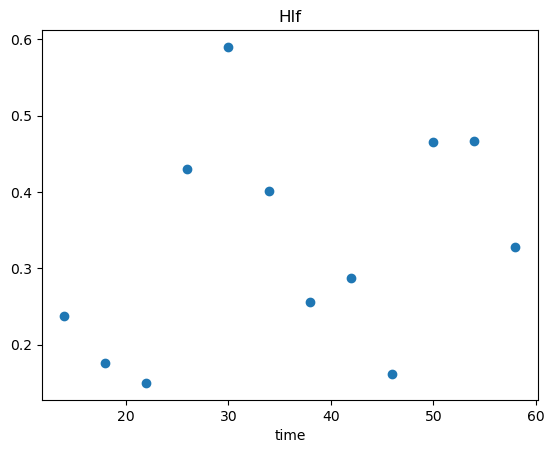

In [66]:
# plot label vs expression of Per1
# take an aavarage of the expression of Per1 for every label

def gene_pos(adata ,gene_name, obs_field="x"):
    v = adata[:, gene_name].X
    pos = adata.obs[obs_field]
    pos_un = pos.unique()
    out = np.zeros(pos_un.shape)

    for i, p in enumerate(pos_un):
        out[i] = np.mean(v[pos == p])

    return out

gene = "Hlf"
# plot label vs expression of Per1
# take an aavarage of the expression of Per1 for every label
plt.scatter(np.unique(labels), gene_pos(E_per, gene, obs_field="labels") )
plt.title(gene)
plt.xlabel("time")


In [67]:
time_points = np.unique(labels)

In [68]:
# now I want the same kind of plot but with the real data
# the positions are given by x_train
# the expression wich will colour cells will be gene Cry1
# the time will be given by labelss

# first of all we want to 
gene = "Hlf"
def video(n):
    # n is teh index of the time point
    t = time_points[n]
    mask = labelss == t
    plt.figure(figsize=(10, 10))
    plt.title("t=" + str(t) + ' number of cells ' + str(mask.sum()))
    plt.scatter(x_train[mask, 0], x_train[mask, 1], c=E_sc[mask_z, gene][mask].layers['norm'], s=100)


interact(video, n=(0, len(time_points) - 1, 1))

interactive(children=(IntSlider(value=5, description='n', max=11), Output()), _dom_classes=('widget-interact',…

<function __main__.video(n)>